In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import pickle
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [50]:
# this defines all of the default colors and markers for the plots

defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0),
            (0.7058823529411765, 0.12156862745098039, 0.4666666666666667),
            (0.4666666666666667, 0.8901960784313725, 0.7607843137254902,),
           ]

fmts = ['-', '--', ':']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]

pred_plot_dict={
    'ls':{'color':defaults[0], 'fmt':fmts[0]},
    'ls_lce':{'color':defaults[0], 'fmt':fmts[1]},
    'ls_svr':{'color':defaults[0], 'fmt':fmts[2]},
    're':{'color':defaults[1], 'fmt':fmts[0]},
    'rea_lce':{'color':defaults[1], 'fmt':fmts[1]},
    'rea_svr':{'color':defaults[1], 'fmt':fmts[2]},
    'bananas/bananas':{'color':defaults[2], 'fmt':fmts[0]},
    'bananas_lce/bananas':{'color':defaults[2], 'fmt':fmts[1]},
    'bananas_svr/bananas':{'color':defaults[2], 'fmt':fmts[2]},    
    'rs':{'color':defaults[3], 'fmt':fmts[0]},
    'hb':{'color':defaults[4], 'fmt':fmts[0]},
    'bohb':{'color':defaults[5], 'fmt':fmts[0]},
    'dehb':{'color':defaults[6], 'fmt':fmts[0]},
}

# define colors, formats, and markers
c_max = 10
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-']*c_max, *['--']*c_max, *[':']*c_max]
markers = [*['^']*c_max, *['v']*c_max, *['o']*c_max]

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

# some of them are not used
pred_label_dict={
    'bananas/gcn':'BANANAS-GCN', 'bananas/bananas':'BANANAS', 'bananas/xgb':'BANANAS-XGB', 
    'npenas/gcn':'NPENAS-GCN', 'npenas/bananas':'NPENAS-BANANAS', 'npenas/xgb':'NPENAS-XGB', 
    'rs':'RS',
    're': 'REA',
    'ls': 'LS',
    'hb': 'HB',
    'bohb': 'BOHB',
    'dehb': 'DEHB',
    'rea_svr': 'REA-SVR',
    'bananas_svr/bananas':'BANANAS-SVR',
    'rea_lce': 'REA-WPM',
    'bananas_lce/bananas':'BANANAS-WPM',
    'ls_svr': 'LS-SVR',
    'ls_lce': 'LS-WPM',
    'ls_svr_hp': 'LS-SVR-HP',
    'rea_svr_hp': 'REA-SVR-HP',
    'bananas_svr_hp/bananas': 'BANANAS-SVR-HP',
}

val_gts = {'cifar10': 91.61, 
           'cifar100': 73.49, 
           'ImageNet16-120': 46.77, 
           'nasbench311': 95.8, 
           'nasbench111':95.6, 
           'nasbenchnlp':100.7}

datasets = {'cifar10': 'cifar10', 
            'cifar100': 'cifar100', 
            'ImageNet16-120': 'ImageNet16-120', 
            'nasbench311': 'cifar10', 
            'nasbench111':'cifar10', 
            'nasbenchnlp':'ptb'}

In [51]:
def merge_and_fill_trajectories(pandas_data_frames, default_value=None):
    # merge all trajectories keeping all time steps
    df = pd.DataFrame().join(pandas_data_frames, how='outer')

    # forward fill to make it a propper step function
    df = df.fillna(method='ffill')
    if default_value is None:
        # backward fill to replace the NaNs for the early times by the
        # performance of a random configuration
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(default_value)
    return df

def get_trajectories(losses, iterations):
    dfs = []
    for i in range(len(losses)):
        loss = losses[i]
        iteration = iterations[i]
        # print('Run %d, Min: %f'%(i, loss))
        df = pd.DataFrame({str(i): loss}, index=iteration)
        dfs.append(df)

    df = merge_and_fill_trajectories(dfs, default_value=None)
    if df.empty:
        pass

    return np.array(df.T), np.array(df.index)

In [52]:
def get_results(predictor, path, metric='valid_acc', key_choice=None):

    output = []
    time = []
    nan_count = 0
    missing_results_count = 0
    file_count = 0
    for folder in os.listdir(path):
        if folder == datasets[key_choice] and os.path.isdir(path + '/' + folder):
            algo_path = path + '/' + folder + '/' + predictor
            seed_dirs = list(os.listdir(algo_path))
            seed_dirs = sorted(seed_dirs, key=lambda x: int(x))

            for seed_dir in seed_dirs:
                if os.path.isdir(algo_path + '/' + seed_dir):
                    result_file = algo_path + '/' + seed_dir + '/errors.json'
                    
                    if os.path.isfile(result_file) and file_count < 100:
                        file_count += 1
                        result = json.load(open(result_file))                        
                        config = result[0]
                        epochs = len(result[1]['train_time'])
                        
                        val_acc = result[1]['valid_acc'][:epochs]

                        if key_choice == 'nasbench111':
                            val_incumbent = [(val_gts[key_choice] - val_acc[0] *  100.) / 100.]
                            for  ind in  range(1, len(val_acc)):
                                val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind]) *100.)  / 100)
                        elif key_choice == 'nasbenchnlp':
                            
                            val_incumbent = [np.exp(100 - val) - val_gts[key_choice] for val in val_acc]
                        else:
                            val_incumbent = [(val_gts[key_choice] - val_acc[0]) / 100]
                            for ind in range(1, len(val_acc)):
                                val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind])) / 100)
                            
                        
                        runtime = result[1]['runtime']
                        train_time = result[1]['train_time']
                        runtime = [sum(runtime[:epoch]) for epoch in range(1, len(runtime)+1)]
                        train_time = [sum(train_time[:epoch]) for epoch in range(1, len(train_time)+1)]
                        total_time = [i+j for i,j in zip(runtime, train_time)]
                        # I think we should just plot validation accs, since that's what the nas algorithm uses
                        if metric == 'valid_acc':
                            incumbent = val_incumbent
                            #incumbent = val_acc
                        elif metric == 'test_acc':
                            test_err = [100 - x for x in result[1]['test_acc']]
                            inc_idx, best, best_idx = [], np.inf, 0
                            for i, err in enumerate(val_err):
                                if err < best:
                                    best, best_idx = err, i
                                inc_idx.append(best_idx)
                            incumbent = [test_err[idx] for idx in inc_idx]
                        
                        if len(incumbent) == epochs:
                            output.append(incumbent)
                            time.append(total_time)
                        else:
                            nan_count += 1

    output = np.array(output)
    time = np.array(time)
    
    output, time = get_trajectories(output, time)
    
    print(predictor, 'output shape', output.shape, 'nans', nan_count, 'missing files', missing_results_count)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(np.var(output, axis=0, ddof=1)/np.asarray(output).shape[0])
    print('first mean', mean[0], 'last mean', mean[-1])
    print('first std', std[0], 'last std', std[-1])
    return mean, std, std_error, time

def save_results_to_dict(folder, predictors, key_choice):
    results_dict = {}
    print('\n saving', key_choice)
    for i, predictor in enumerate(predictors):
        mean, std, std_error, runtime = get_results(predictor, folder, metric='valid_acc', key_choice=key_choice)
        key = predictor
        results_dict[key] = {'label':pred_label_dict[predictor], 
                             'key':key, 'mean':mean, 'std':std, 
                             'std_error': std_error, 'runtime': runtime}
    return results_dict

In [53]:
def save_all_results():
    
    all_results = {}

     
    # without noise
    key_choice = 'nasbench111'
    folder = os.path.expanduser(base_path + 'nas111/')
    predictors=(
                'hb', 'bohb', 'bananas_svr/bananas',
                'rs', 're', 'rea_svr', 'ls', 'rea_lce', 'ls_svr', 'ls_lce',
                'bananas/bananas',  'bananas_lce/bananas'
                ) 
    all_results[key_choice] = save_results_to_dict(folder, predictors, key_choice)   
            
    key_choice = 'nasbench311'
    folder = os.path.expanduser(base_path + 'nas311/')
    predictors=(
                'hb', 'bananas_svr/bananas',
                'rs', 're', 'rea_svr', 'ls', 'rea_lce', 'ls_svr', 'ls_lce',
                'bananas/bananas',  'bananas_lce/bananas'
                )
    all_results[key_choice] = save_results_to_dict(folder, predictors, key_choice) 

    key_choice = 'nasbenchnlp'
    folder = os.path.expanduser(base_path + 'nasnlp11/')
    predictors=(
                'hb', 'bananas_svr/bananas',
                'rs', 're', 'rea_svr', 'ls', 'rea_lce', 'ls_svr', 'ls_lce',
                'bananas/bananas',  'bananas_lce/bananas'
                )
    all_results[key_choice] = save_results_to_dict(folder, predictors, key_choice) 
    
    return all_results

In [54]:
base_path = '~/nas-bench-x11/results/'

results = save_all_results()


 saving nasbench111
hb output shape (30, 51906) nans 0 missing files 0
first mean 0.42581538123025936 last mean 0.007113982219774485
first std 0.044700821483236855 last std 0.0015319397680535816
bohb output shape (30, 29564) nans 0 missing files 0
first mean 0.42581538123025936 last mean 0.00733834153247056
first std 0.044700821483236855 last std 0.0020663055592110946
bananas_svr/bananas output shape (30, 19020) nans 0 missing files 0
first mean 0.045701338089168514 last mean 0.0015147765646715968
first std 0.03409270567970239 last std 0.0017293603917026546
rs output shape (30, 13808) nans 0 missing files 0
first mean 0.045701338089168514 last mean 0.008216140928109435
first std 0.03409270567970239 last std 0.001902040770204767
re output shape (30, 11358) nans 0 missing files 0
first mean 0.045701338089168514 last mean 0.005841824073728063
first std 0.03409270567970239 last std 0.0016488201952069635
rea_svr output shape (30, 30684) nans 0 missing files 0
first mean 0.04570133808916851

In [59]:
result_folder = 'plots_oct26/nas/'
if not os.path.exists(result_folder):
    os.mkdirs(result_folder)

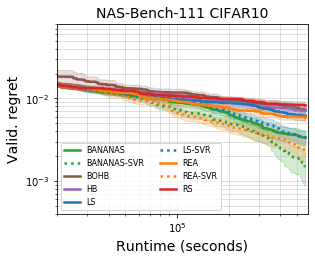

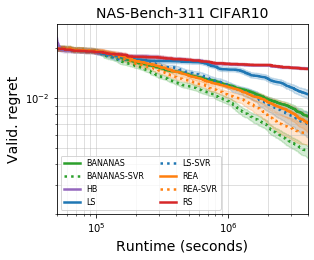

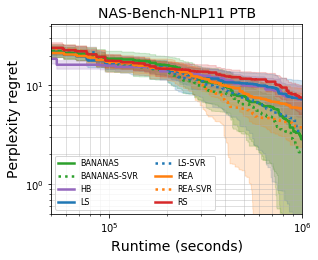

In [60]:
# plot performance vs runtime

for key_choice in results.keys():
    results_dict = results[key_choice]


    if key_choice == 'nasbenchnlp':
        keys = ['bananas/bananas', 'hb', 'ls', 'rs', 're', 'ls_svr', 'rea_svr', 'bananas_svr/bananas']

    elif key_choice=='nasbench111':
        keys = ['bananas/bananas', 'hb', 'bohb', 'ls', 'rs', 're', 'ls_svr', 'rea_svr', 'bananas_svr/bananas']
    else:
        keys = ['bananas/bananas', 'hb', 'ls', 'rs', 're', 'ls_svr', 'rea_svr', 'bananas_svr/bananas']


    keys = sorted(keys)

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = 'dotted'
    add_sub_axes = False

    fig, ax = plt.subplots(figsize=[4.5, 3.5])
    if add_sub_axes:
        sub_axes = plt.axes([.6, .5, .3, .38]) 


    for i, key in enumerate(keys):
        mean = results_dict[key]['mean']
        sem = results_dict[key]['std_error']
        label = results_dict[key]['label']
        x = results_dict[key]['runtime']
        #tag = '_'.join(key.split('_')[:-1])
        tag = key
        color = pred_plot_dict[tag]['color']
        fmt = pred_plot_dict[tag]['fmt']
        ax.plot(x, mean, label=label, color=color, linestyle=fmt, linewidth=2.5)
        ax.fill_between(x, mean-2*sem, mean+2*sem,
                        color=color, alpha=0.2)

        if add_sub_axes:
            n = 450
            X_detail = x[n:]
            Y_detail = mean[n:]
            sem_detail = sem[n:]
            sub_axes.plot(X_detail, Y_detail, color=color, linestyle=fmt)
            sub_axes.tick_params(labelbottom=False) 

    ax.set_xlabel('Runtime (seconds)', fontsize=14)

    if key_choice == 'nasbenchnlp':
        ax.set_ylabel('Perplexity regret', fontsize=14) #nas201
    else:
        ax.set_ylabel('Valid. regret', fontsize=14) #nas201

    ax.grid(True, which="both",ls="-", alpha=.5)

    if key_choice == 'cifar10':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.001, .19])
        ax.set_xlim([1e4, 4*10e4])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 CIFAR10', fontsize=14)
        plt.savefig(os.path.expanduser(result_folder + 'nas201_c10.pdf'), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'cifar100':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([0.002, 0.3])
        ax.set_xlim([1e4, 8.1e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 CIFAR100', fontsize=14)
        plt.savefig(os.path.expanduser(result_folder + 'nas201_c100.pdf'), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'ImageNet16-120':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.002, .4])
        ax.set_xlim([1e4, 1.0e6])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-201 ImageNet16-120', fontsize=14, loc='right')
        plt.savefig(os.path.expanduser(result_folder + 'nas201_im.pdf'), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'nasbench311':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([2e-3, .028])
        ax.set_xlim([5e4, 4*10e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-311 CIFAR10', fontsize=14)
        plt.savefig(os.path.expanduser(result_folder + 'nas311_c10.pdf'), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbench111':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([4e-4, 8e-2])
        ax.set_xlim([2e4, 5.8*10e4])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-111 CIFAR10', fontsize=14)
        plt.savefig(os.path.expanduser(result_folder + 'nas111_c10.pdf'), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbenchnlp':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.5, 4.2e1])
        ax.set_xlim([5e4, 1.0*10e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-NLP11 PTB', fontsize=14)
        plt.savefig(os.path.expanduser(result_folder + 'nasn11_ptb.pdf'), bbox_inches = 'tight', pad_inches = 0.1)


# ablation experiments

In [67]:
mf_results = {}

key_choice = 'nasbench311'
predictors=(
            'bananas_svr/bananas', 'rea_svr', 'ls_svr', 'rea_lce',  'ls_lce', 'bananas_lce/bananas'
            )

save = '10'
folder = os.path.expanduser(base_path + 'nas301_mf/nas301_s10_0/')
mf_results[save] = save_results_to_dict(folder, predictors, key_choice) 

save = '20'
folder = os.path.expanduser(base_path + 'nas301_mf/nas301_s20_0/')
mf_results[save] = save_results_to_dict(folder, predictors, key_choice) 


save = '30'
folder = os.path.expanduser(base_path + 'nas301_mf/nas301_s30_0/')
mf_results[save] = save_results_to_dict(folder, predictors, key_choice) 


save = '40'
folder = os.path.expanduser(base_path + 'nas301_mf/nas301_s40_0/')
mf_results[save] = save_results_to_dict(folder, predictors, key_choice) 


 saving nasbench311
bananas_svr/bananas output shape (20, 32924) nans 0 missing files 0
first mean 0.027690476997605025 last mean 0.008070368182565572
first std 0.006019505101282804 last std 0.0019988022210262533
rea_svr output shape (30, 44486) nans 0 missing files 0
first mean 0.0277392917169946 last mean 0.009287329902176546
first std 0.0059934992464833895 last std 0.0014578408697008848
ls_svr output shape (30, 54497) nans 0 missing files 0
first mean 0.0277392917169946 last mean 0.00970684007196442
first std 0.0059934992464833895 last std 0.0019135014103462084
rea_lce output shape (30, 10955) nans 0 missing files 0
first mean 0.0277392917169946 last mean 0.00862607370720128
first std 0.0059934992464833895 last std 0.0018879481905400414
ls_lce output shape (30, 12250) nans 0 missing files 0
first mean 0.0277392917169946 last mean 0.012602414781621584
first std 0.0059934992464833895 last std 0.0014094999958035054
bananas_lce/bananas output shape (30, 11411) nans 0 missing files 0
fi

key bananas_lce/bananas fid 10 idx 10847 of 11411
key bananas_lce/bananas fid 20 idx 17209 of 18313
key bananas_lce/bananas fid 30 idx 26329 of 27854
key bananas_lce/bananas fid 40 idx 21532 of 22821
key bananas_svr/bananas fid 10 idx 30091 of 32924
key bananas_svr/bananas fid 20 idx 24083 of 25996
key bananas_svr/bananas fid 30 idx 22433 of 23963
key bananas_svr/bananas fid 40 idx 21218 of 22594
key ls_lce fid 10 idx 11641 of 12250
key ls_lce fid 20 idx 16798 of 17834
key ls_lce fid 30 idx 27664 of 29448
key ls_lce fid 40 idx 22501 of 23849
key ls_svr fid 10 idx 49211 of 54497
key ls_svr fid 20 idx 29402 of 31895
key ls_svr fid 30 idx 20148 of 21516
key ls_svr fid 40 idx 17692 of 18725
key rea_lce fid 10 idx 10399 of 10955
key rea_lce fid 20 idx 13112 of 13878
key rea_lce fid 30 idx 25274 of 26807
key rea_lce fid 40 idx 19877 of 21028
key rea_svr fid 10 idx 40292 of 44486
key rea_svr fid 20 idx 23774 of 25910
key rea_svr fid 30 idx 16107 of 17245
key rea_svr fid 40 idx 13881 of 14874


Text(0.5, 1.0, 'NAS-Bench-311 CIFAR10')

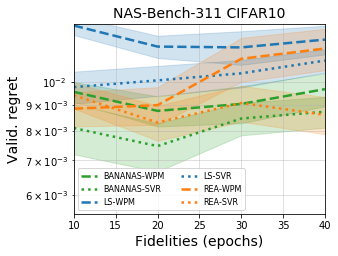

In [66]:
result_folder = 'plots_june3/nas/'
results_dict = mf_results['10']


keys=('bananas_svr/bananas', 'rea_svr', 'ls_svr', 'rea_lce',  'ls_lce', 'bananas_lce/bananas')
keys = sorted(keys)

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = 'dotted'

fig, ax = plt.subplots(figsize=[4.5, 3.5])

fidelities = [10, 20, 30, 40]
runtime = 1.9e6

for i, key in enumerate(keys):

    label = results_dict[key]['label']
    tag = key
    color = pred_plot_dict[tag]['color']
    fmt = pred_plot_dict[tag]['fmt']
    
    fid_means = []
    fid_sems = []
    for fid in fidelities:
        mean = mf_results[str(fid)][key]['mean']
        sem = mf_results[str(fid)][key]['std_error']
        x = mf_results[str(fid)][key]['runtime'] 
        idx = 0
        while x[idx] < runtime:
            idx += 1
        print('key', key, 'fid', fid, 'idx', idx, 'of', len(x))
        fid_means.append(mean[idx])
        fid_sems.append(sem[idx])
    fid_means = np.array(fid_means)
    fid_sems = np.array(fid_sems)
    
    ax.plot(fidelities, fid_means, label=label, color=color, linestyle=fmt, linewidth=2.5)
    ax.fill_between(fidelities, fid_means-2*fid_sems, fid_means+2*fid_sems,
                    color=color, alpha=0.2)

ax.set_xlabel('Fidelities (epochs)', fontsize=14)


ax.set_ylabel('Valid. regret', fontsize=14) #nas201

ax.grid(True, which="both",ls="-", alpha=.5)


#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5.5e-3, 1.3e-2]) #when runtime = 1e6

ax.set_xlim([10, 40])
ax.legend(ncol=2, loc=3, fontsize=8)
ax.set_title('NAS-Bench-311 CIFAR10', fontsize=14)
#plt.savefig(os.path.expanduser(result_folder + 'nas311_ablation.pdf'), bbox_inches = 'tight', pad_inches = 0.1)
